# Chest X-Ray Images for Pneumonia

## Table of Contents

1. Introduction
2. Importing Data
3. Creating plotting functions 
4. Setting up Training and Testing Data
5. Convolutional Neural Network 1
6. Convolutional Neural Network 2

### 1. Introduction

In this notebook, I will be creating two different models and evaluating their effectiveness on our data. The goal is to find the best model for predicting whether a patient has pneumonia based on a chest X-ray. 

### 2. Importing Data

In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
from PIL import Image
import seaborn as sns
import random

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn import preprocessing

In [2]:
categories = ['NORMAL', 'PNEUMONIA']
datasets = ['train', 'test']

In [3]:
widths = []
heights = []

for sets in datasets:
    for cat in categories:
        filelist = glob.glob('/Users/kasey.larsen/Documents/GitHub/Chest-X-Ray-Images-Pneumonia-/chest_xray/' + 
                             sets + '/' + cat + '/*.jpeg')
        widths.extend([Image.open(fname).size[0] for fname in filelist])
        heights.extend([Image.open(fname).size[1] for fname in filelist])

images_size = pd.DataFrame({"widths": widths, "heights": heights})
        
print("Average image width: ", round(images_size["widths"].mean(), 2))
print("Average image height: ", round(images_size["heights"].mean(), 2))

Average image width:  1327.83
Average image height:  970.6


In [4]:
im_width = int(images_size["widths"].mean()/10)
im_height = int(images_size["heights"].mean()/10)
print("image width: " , str(im_width))
print("image height: " , str(im_height))

image width:  132
image height:  97


### 3. Creating plotting functions 

In [5]:
# This function will plot the confusion matrix in a heat map for each model

def plot_confusion(con_mat):
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(con_mat, annot=True,cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Model Accuracy')
    plt.show()

In [6]:
# This function will plot the images with their predicted labels and true labels

def plot_model_images():

    fig = plt.figure(figsize=(20,25))
    gs = fig.add_gridspec(8, 4)

    for row in range(0, 8):
        for col in range(0, 3):
            num_image = random.randint(0, X_test.shape[0])
            ax = fig.add_subplot(gs[row, col])
            ax.axis('off');
            ax.set_title("Predicted: " + categories[int(np.round(y_pred)[num_image][0])] + " /\n True value: " + 
                         categories[y_test[num_image]])
            ax.imshow(X_test[num_image]);
    fig.suptitle("Predicted label VS True label \n for the displayed chest X Ray pictures", fontsize=25, x=0.42);

In [7]:
# This function will plot the accuracy and loss history for the model

plt.rcParams['figure.figsize'] = (12, 14)
def plot_accuracy_loss():
    fig, axes = plt.subplots(2, 1)
    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    axes[0].set_title('Model Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Test'], loc='upper left')
    
    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set_title('Model Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Train', 'Test'], loc='upper left')

### 4. Setting up Training and Testing Data

In [8]:
X = []
y = []

for sets in datasets:
    for cat in categories:
        filelist = glob.glob('/Users/kasey.larsen/Documents/GitHub/Chest-X-Ray-Images-Pneumonia-/chest_xray/' + sets + '/' + cat + '/*.jpeg')
        y.extend([cat for _ in filelist])
        X.extend([np.array(Image.open(fname).convert('L').resize((im_width, im_height))) for fname in filelist])
# 
X_array = np.stack(X, axis=0)

In [9]:
for n, i in enumerate(y):
    if i == 'NORMAL':
        y[n] = 0
    else:
        y[n] = 1

In [10]:
y_array = np.array(y)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, random_state=43, test_size=0.2, stratify=y)

In [12]:
X_train.shape

(4672, 97, 132)

In [13]:
X_test.shape

(1168, 97, 132)

In [14]:
y_train.shape

(4672,)

In [15]:
y_test.shape

(1168,)

In [16]:
X_train = X_train.reshape(4672, 97, 132, 1)
X_test = X_test.reshape(1168, 97, 132, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train  /= 255
X_test /= 255

### 5. Convolutional Neural Network 1

In [17]:
batch_size = 32 
# 32 examples in a mini-batch, smaller batch size means more updates in one epoch

epochs = 100 # repeat 100 times

In [18]:
def base_model():

    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(im_height, im_width, 1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32,(3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

# Train model

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

cnn_n = base_model()
cnn_n.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 97, 132, 32)       320       
_________________________________________________________________
activation (Activation)      (None, 97, 132, 32)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 66, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 64, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 46, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 32, 32)        0

In [19]:
es = tf.keras.callbacks.EarlyStopping(patience=15, monitor='val_accuracy', restore_best_weights=True)
history = cnn_n.fit(X_train, y_train, epochs=epochs, validation_split=0.3, callbacks=[es])
print(history.history.keys())

Epoch 1/100
103/103 [==============================] - 30s 285ms/step - loss: 0.4239 - accuracy: 0.8073 - val_loss: 0.4770 - val_accuracy: 0.7532
Epoch 2/100
103/103 [==============================] - 35s 342ms/step - loss: 0.2004 - accuracy: 0.9205 - val_loss: 0.1941 - val_accuracy: 0.9379
Epoch 3/100
103/103 [==============================] - 40s 385ms/step - loss: 0.1584 - accuracy: 0.9419 - val_loss: 0.1549 - val_accuracy: 0.9437
Epoch 4/100
103/103 [==============================] - 40s 384ms/step - loss: 0.1384 - accuracy: 0.9474 - val_loss: 0.1448 - val_accuracy: 0.9422
Epoch 5/100
103/103 [==============================] - 40s 387ms/step - loss: 0.1309 - accuracy: 0.9520 - val_loss: 0.1627 - val_accuracy: 0.9394
Epoch 6/100
103/103 [==============================] - 41s 396ms/step - loss: 0.1196 - accuracy: 0.9563 - val_loss: 0.1328 - val_accuracy: 0.9465
Epoch 7/100
103/103 [==============================] - 41s 395ms/step - loss: 0.1181 - accuracy: 0.9575 - val_loss: 0.1268 -

In [20]:
y_pred=cnn_n.predict(X_test)
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

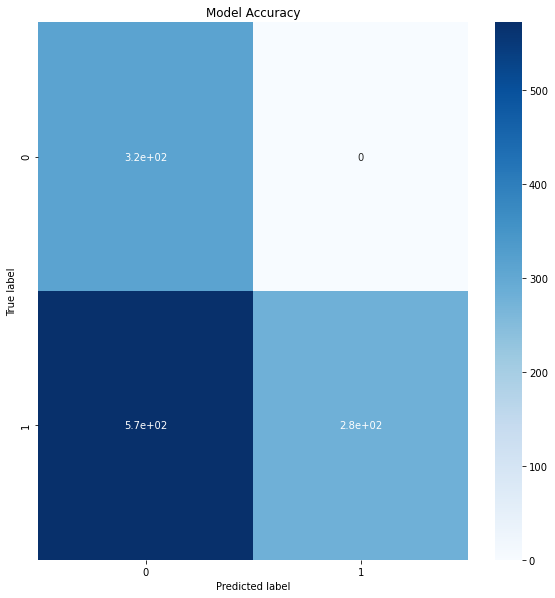

In [21]:
plot_confusion(con_mat)

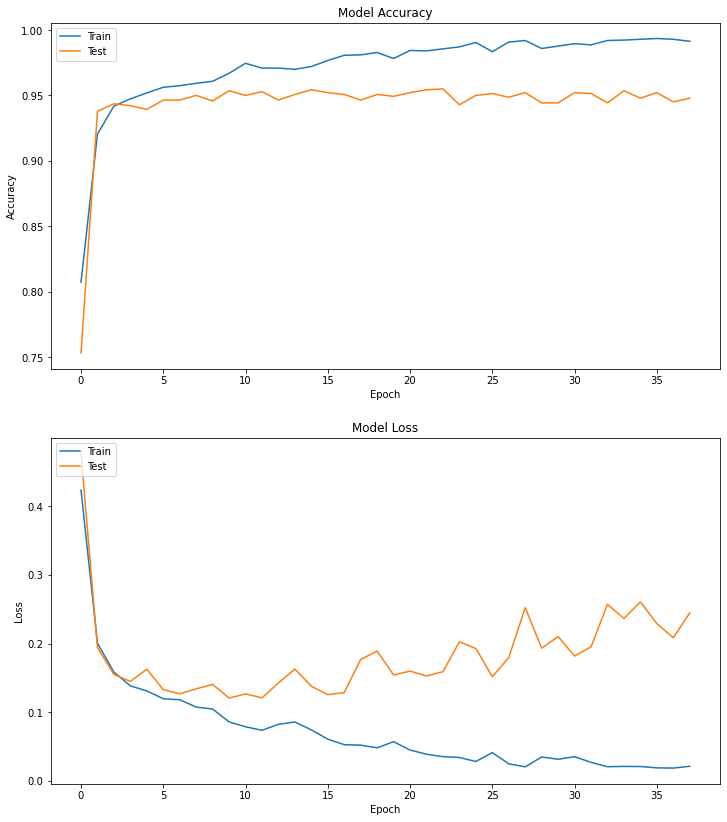

In [22]:
plot_accuracy_loss()

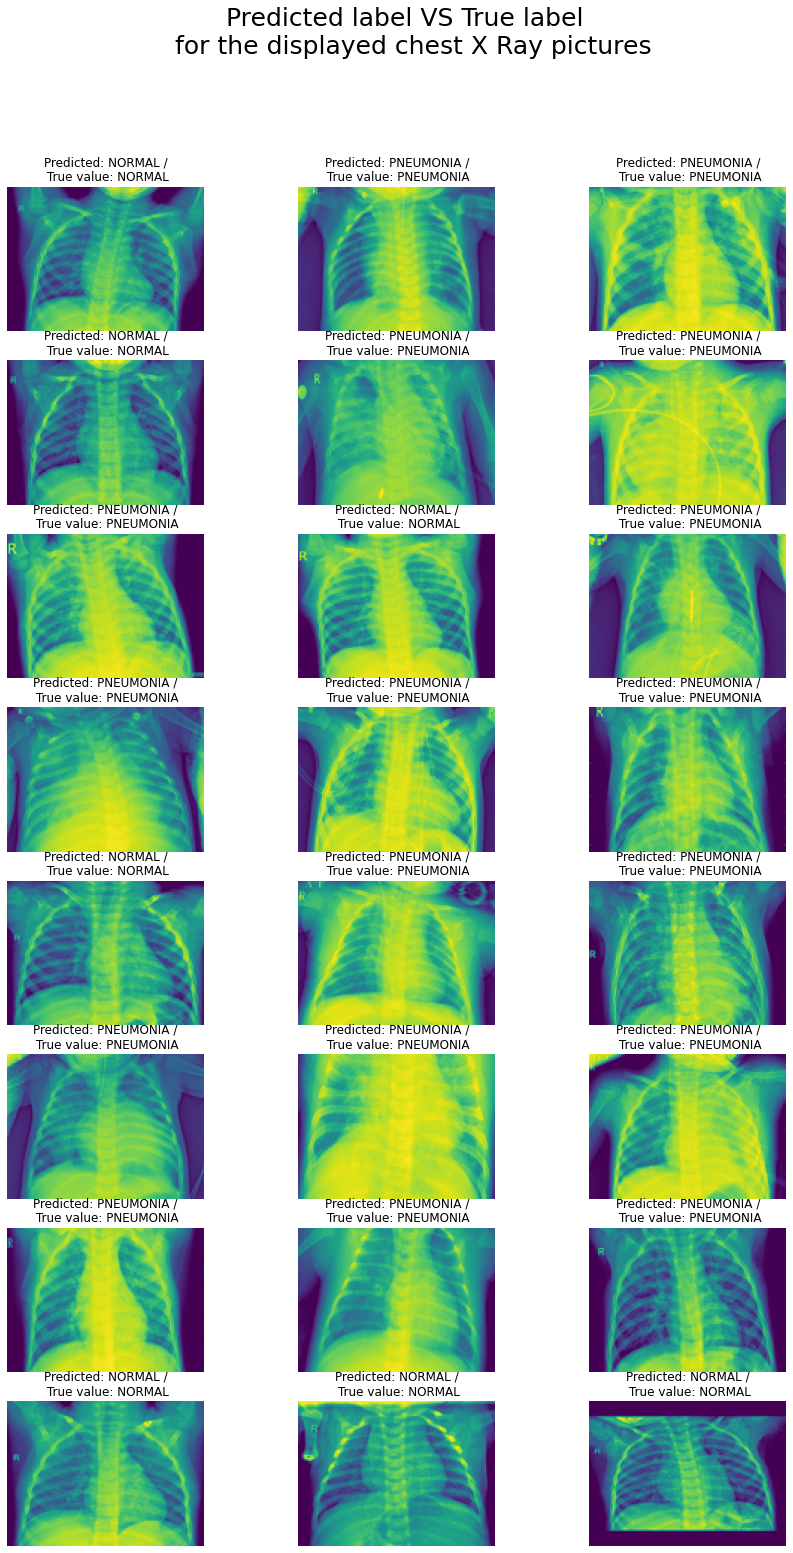

In [23]:
plot_model_images()

### 6. Convolutional Neural Network 2

In [24]:
def base_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(im_height, im_width, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(32,(3,3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
    model.add(Dropout(0.2))

    model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
    model.add(Dropout(0.2))

    model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1024,activation='relu',kernel_constraint=maxnorm(3)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))


# Train model

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

cnn_n = base_model()
cnn_n.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 97, 132, 32)       320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 66, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 48, 66, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 48, 66, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 33, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 33, 64)        18496     
_________________________________________________________________
dropout_4 (Dropout)          (None, 24, 33, 64)       

In [25]:
es = tf.keras.callbacks.EarlyStopping(patience=15, monitor='val_accuracy', restore_best_weights=True)
history = cnn_n.fit(X_train, y_train, epochs=epochs, validation_split=0.3, callbacks=[es])
print(history.history.keys())

Epoch 1/100
103/103 [==============================] - 53s 503ms/step - loss: 0.5582 - accuracy: 0.7419 - val_loss: 0.4704 - val_accuracy: 0.7461
Epoch 2/100
103/103 [==============================] - 52s 501ms/step - loss: 0.2861 - accuracy: 0.8777 - val_loss: 0.2695 - val_accuracy: 0.9087
Epoch 3/100
103/103 [==============================] - 51s 498ms/step - loss: 0.2024 - accuracy: 0.9208 - val_loss: 0.2178 - val_accuracy: 0.9208
Epoch 4/100
103/103 [==============================] - 52s 503ms/step - loss: 0.1507 - accuracy: 0.9443 - val_loss: 0.1651 - val_accuracy: 0.9315
Epoch 5/100
103/103 [==============================] - 51s 498ms/step - loss: 0.1344 - accuracy: 0.9477 - val_loss: 0.1488 - val_accuracy: 0.9365
Epoch 6/100
103/103 [==============================] - 52s 500ms/step - loss: 0.1204 - accuracy: 0.9544 - val_loss: 0.1406 - val_accuracy: 0.9422
Epoch 7/100
103/103 [==============================] - 51s 497ms/step - loss: 0.1152 - accuracy: 0.9578 - val_loss: 0.2181 -

In [26]:
y_pred=cnn_n.predict(X_test)
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

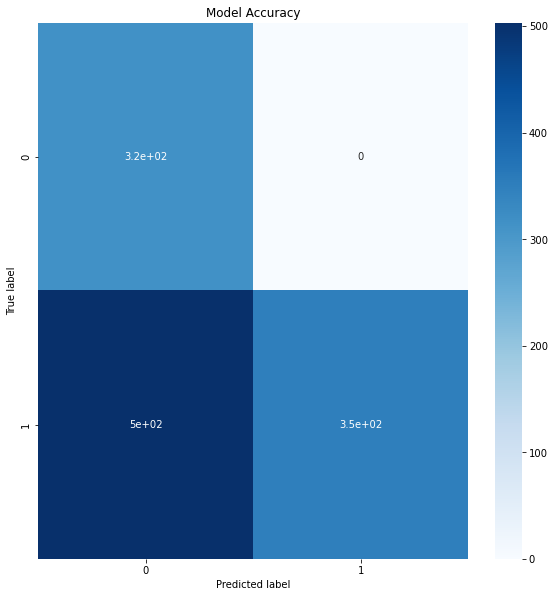

In [27]:
plot_confusion(con_mat)

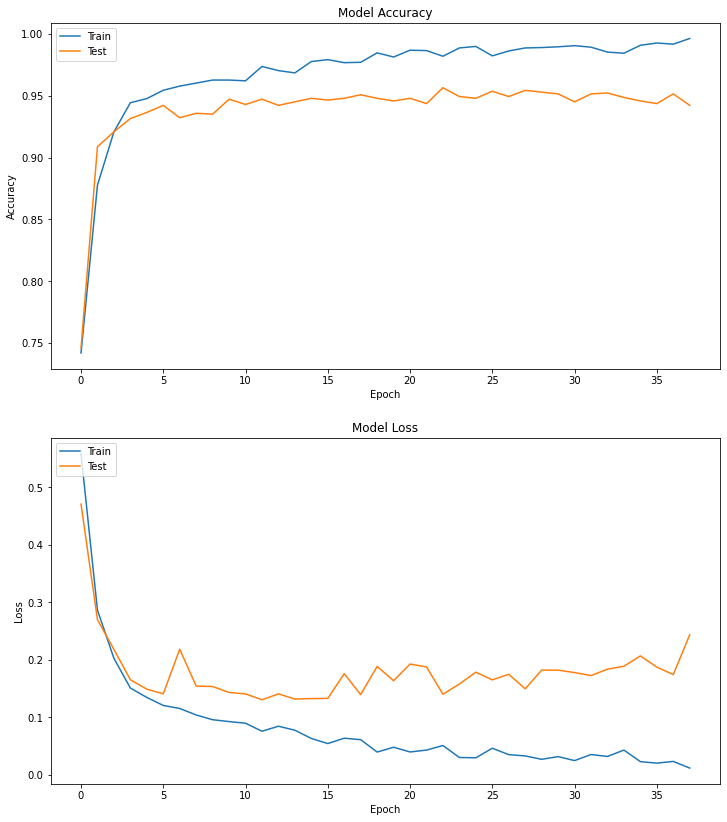

In [28]:
plot_accuracy_loss()

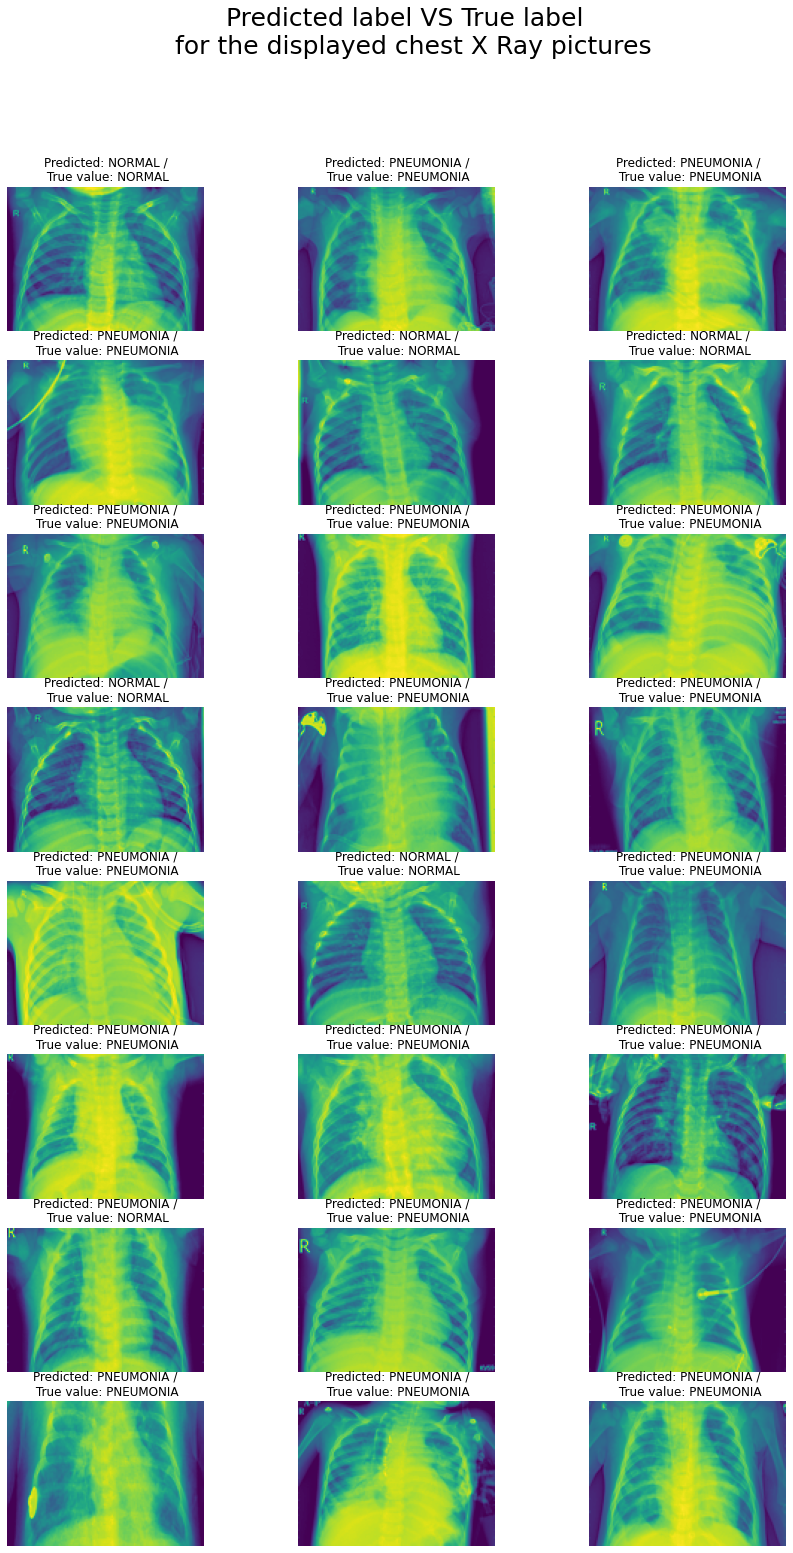

In [29]:
plot_model_images()